<a href="https://colab.research.google.com/github/1aidea/cs480student/blob/main/06/Copy_of_CS480_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

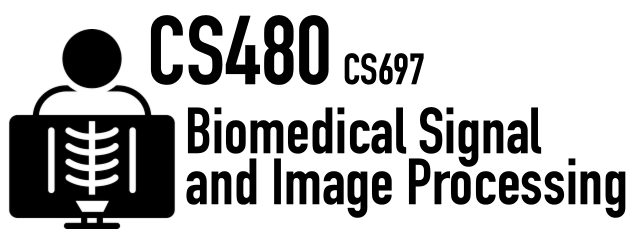
#Assignment 6

In [1]:
# In this assignment, we will train a U-Net classifer to detect mitochondria
# in electron microscopy images!

In [2]:
### IMPORTANT ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [3]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# load the unet tensorflow code
!pip install git+https://github.com/jakeret/unet.git

  Cloning https://github.com/jakeret/unet.git to /tmp/pip-req-build-j5zg4hm2
  Running command git clone -q https://github.com/jakeret/unet.git /tmp/pip-req-build-j5zg4hm2
  Created wheel for unet: filename=unet-0.0.post0.dev81+gf557a51-py2.py3-none-any.whl size=25688 sha256=ebaf85b9f7792a11d8f326c0655db1ed83d1883ed14cb9f9a7ece9f95c39058a
  Stored in directory: /tmp/pip-ephem-wheel-cache-c2lgjojh/wheels/22/00/93/ce57529ed355f160088cbb6ce086e55168770913b40cf624ba
Successfully built unet


In [5]:
# .. and use it!
# Note: There are a ton of U-Net implementations but this one is easier to use!

import unet

**Task 1**: Study the unet circle example and learn about mitochondria! [15 Points]

In [6]:
# The unet package allows to train a U-Net classifier with little code.
# As discussed in class, the U-Net can be used to label/segment/annotate images.

In [7]:
# TODO: Please study the Circles example 
# https://github.com/jakeret/unet/blob/master/notebooks/circles.ipynb

In [8]:
# TODO: ... and look how the (artificial) dataset is generated
# https://github.com/jakeret/unet/blob/master/src/unet/datasets/circles.py

In [9]:
# 1) Question
# TODO: Please describe what the U-Net is trained to do.
# 
# TODO: YOUR ANSWER

"""
This U-Net is trained to de-noise images of circles. The input is images of
circles with random noise. The labels are masks of the images which is the 
expected output of the image without any noise. The program uses the mask to
train the images to better improve the de noising.
"""

'\nThis U-Net is trained to de-noise images of circles. The input is images of\ncircles with random noise. The labels are masks of the images which is the \nexpected output of the image without any noise. The program uses the mask to\ntrain the images to better improve the de noising.\n'

In [10]:
# 2) Question
# TODO: In circles.py, what does the following mean:
#     channels = 1
#     classes = 2
#
# TODO: YOUR ANSWER
"""
Channels in circles.py is refering to the color channels that will be used
to create the images. Since our images are in black and white we will be using
grayscale images which only require 1 channel. 

Classes are the number of classifications. Either we have a circle detected or 
we don't.
"""

"\nChannels in circles.py is refering to the color channels that will be used\nto create the images. Since our images are in black and white we will be using\ngrayscale images which only require 1 channel. \n\nClasses are the number of classifications. Either we have a circle detected or \nwe don't.\n"

In [11]:
# 3) Question
# TODO: What are mitochondria and what is their appearance in
# electron microscopy data?
# Hint: You can validate your answer in Task 4!
#
# TODO: YOUR ANSWER
"""
The mitochondria is the powerhouse of the cell. It produces energy.
Their appearence is the shape of a dark semi circlular object within the images.

after completing task 4 ... 
"""

'\nThe mitochondria is the powerhouse of the cell. It produces energy.\nTheir appearence is the shape of a dark semi circlular object within the images.\n\nafter completing task 4 ... \n'

**Task 2**: Setup a datagenerator for mitochondria images! [45 Points]

In [12]:
# TODO: 
# Download https://cs480.org/data/mito.npz to your computer.
# Then, please upload mito.npz using the file panel on the left.

In [13]:
# The code below is similar to the circles.py file from Task 1.
# We follow Tensorflow conventions to design a tf.data.Dataset for training
# the U-Net.
#
# TODO: Please add four different data augmentation methods in the code block
# below. (image normalization to 0..1, horizontal data flip, vertical data flip,
# rotation by 90 degrees)
#
# Hint: https://github.com/jakeret/unet/blob/master/src/unet/datasets/oxford_iiit_pet.py#L25

In [42]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_datasets.core import DatasetInfo
from typing import Tuple, List

IMAGE_SIZE = (256, 256)
channels = 1
classes = 2

def load_data(count:int, splits:Tuple[float]=(0.7, 0.2, 0.1), **kwargs) -> List[tf.data.Dataset]:
    return [tf.data.Dataset.from_tensor_slices(_build_samples(int(split * count), **kwargs))
            for split in splits]


def _build_samples(sample_count:int, **kwargs) -> Tuple[np.array, np.array]:

    # here we load the mitochondria data
    loaded = np.load('mito.npz')
    loadedimages = loaded['arr_0'][0].copy()
    loadedmasks = loaded['arr_0'][1].copy()

    # now let's go to numpyland
    images = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    labels = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 2))
    for i in range(sample_count):
        image, mask = loadedimages[i], loadedmasks[i]

        image = image.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)).astype(np.float)
        mask = mask.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

        #
        # TODO: Normalize the image to 0..1
        #
        # TODO: YOUR CODE
        image = image / 255.0

        #
        # TODO: Use Tensorflow to flip the image horizontally
        #
        if tf.random.uniform(()) > 0.5:
            #
            # TODO: YOUR CODE
            #
            tf.image.flip_up_down(image)
            

        #
        # TODO: Use Tensorflow to flip the image vertically
        #
        if tf.random.uniform(()) > 0.5:
            #
            # TODO: YOUR CODE
            #
            tf.image.flip_left_right(image)


        #
        # TODO: Use Tensorflow to rotate the image 90 degrees
        #
        if tf.random.uniform(()) > 0.5:
            #
            # TODO: YOUR CODE
            #
            image = tf.image.rot90(image)


        # augmentation done, let's store the image
        images[i] = image

        # here we split the mask to background and foreground
        fg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        fg[mask == 255] = 1
        bg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        bg[mask == 0] = 1
        
        labels[i, :, :, 0] = bg[:,:,0]
        labels[i, :, :, 1] = fg[:,:,0]

    return images, labels

**Task 3**: Let's train the U-Net! [25 Points]

In [45]:
#
# We can now create our training, validation, and testing data by calling
# our methods from Task 2.
#
train, val, test = load_data( 660, splits=(0.7, 0.2, 0.1) )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the bu

In [17]:
# 1) Question
# TODO: We have in total 660 images + 660 masks. Based on the code above,
# how many images are used for training alone?
#
# TODO: YOUR ANSWER
"""
660 * 70% = 462 images for training
660 * 20% = 132 images for validation
660 * 10% = 66 images for testing
"""

'\n660 * 70% = 462 images for training\n660 * 20% = 132 images for validation\n660 * 10% = 66 images for testing\n'

In [46]:
#
# Let's setup the U-Net!
#
LEARNING_RATE = 1e-3

unet_model = unet.build_model(channels=channels,
                              num_classes=classes,
                              layer_depth=5,
                              filters_root=64,
                              padding="same")

unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

In [47]:
#
# And, let's setup the trainer...
#
trainer = unet.Trainer(checkpoint_callback=False,
                       learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
                       warmup_proportion=0.1,
                       learning_rate=LEARNING_RATE)

In [48]:
#
# ...and train the U-Net for 50 epochs with a batch_size of 10!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use training and validation data.
# Hint 2: This will take roughly 30 minutes!
#
trainer.fit(unet_model,
            train,
            val,
            epochs=5,
            batch_size=10
            )

Epoch 1/5
47/47 [==============================] - 70s 1s/step - loss: 0.3617 - categorical_crossentropy: 0.3617 - categorical_accuracy: 0.8924 - mean_iou: 0.4191 - dice_coefficient: 0.7837 - auc_2: 0.9202 - learning_rate: 7.2062e-04 - val_loss: 0.2276 - val_categorical_crossentropy: 0.2276 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.4448 - val_dice_coefficient: 0.8447 - val_auc_2: 0.9629
Epoch 2/5
47/47 [==============================] - 65s 1s/step - loss: 0.3076 - categorical_crossentropy: 0.3076 - categorical_accuracy: 0.9115 - mean_iou: 0.4390 - dice_coefficient: 0.8237 - auc_2: 0.9325 - learning_rate: 7.7604e-04 - val_loss: 0.2128 - val_categorical_crossentropy: 0.2128 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.4561 - val_dice_coefficient: 0.8704 - val_auc_2: 0.9632
Epoch 3/5
47/47 [==============================] - 64s 1s/step - loss: 0.3211 - categorical_crossentropy: 0.3211 - categorical_accuracy: 0.9115 - mean_iou: 0.4392 - dice_coefficient: 0.8304 - auc_2:

**Task 4**: Let's predict mitochondria in the testing data! [15 Points]

In [ ]:
# 
# After training, let's try the U-Net on our testing data.
#
# The code below displays the first 10 input images, the original masks by experts, 
# and the predicted masks from the U-Net.

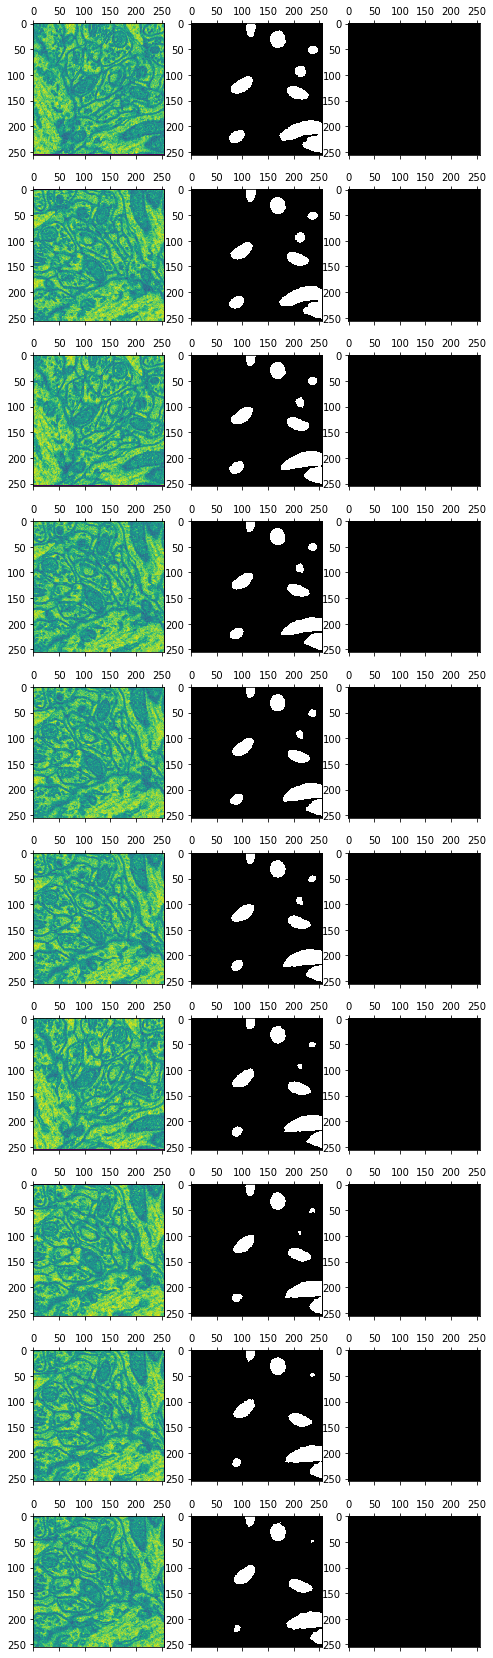

In [51]:
rows = 10
fig, axs = plt.subplots(rows, 3, figsize=(8, 30))
for ax, (image, label) in zip(axs, test.take(rows).batch(1)):
  
  prediction = unet_model.predict(image)
  ax[0].matshow(image[0, :, :, 0])
  ax[1].matshow(label[0, :, :, 1], cmap="gray")
  ax[2].matshow(prediction[0].argmax(axis=-1), cmap="gray")

In [50]:
# 1) Question
# TODO: Why do we use the prediction[0].argmax(axis=-1) command
# to display the prediction?
# 
# TODO: YOUR ANSWER
"""
We use this command inorder to see the highest predicted image classification
from the prediction array.
"""

'\nWe use this command inorder to see the highest predicted image classification\nfrom the prediction array.\n'

In [ ]:
# 2) Question
# TODO: Is the quality of the segmentation good and how could we improve it?
# Hint: Think along the lines of some traditional image processing rather than
# increasing the training data size.
#
# TODO: YOUR ANSWER

In [ ]:
"""
The quality of the segmentation is ok, however, we could apply more processing
techniques such as gaussian blur to help reduce the changes and better spot
the mitocondreas. Another alternative is to use more training data. However, if 
this is limited then we could try other data splitting methods such as 
k-fold cross validation.
"""

**Bonus**: Compare against the state-of-the-art literature! [33 Points]

In [ ]:
#
# The following paper also uses a 2D U-Net to detect mitochondria:
# 
# https://danielhaehn.com/papers/?casser2020fast
#

In [ ]:
# 1) Question
#
# TODO: How many learnable parameters does your trained unet_model have?
# Hint: You can use TF's Model Summary function to answer this.
#

In [ ]:
# TODO: YOUR CODE

In [ ]:
# 2) Question
#
# TODO: How many parameters do Casser et al. use?
#

In [ ]:
# TODO: YOUR ANSWER

In [ ]:
"""
Encoder 1,178,480
Decoder 780,053
"""

In [ ]:
# 3) Question
#
# TODO: How did Casser et al. reduce the parameters?
#

In [ ]:
# TODO: YOUR ANSWER

In [ ]:
"""
He reduced the parameter size by decreasing the size of the layers.
"""

In [ ]:
# 4) Question
#
# TODO: Why did Casser et al. reduce the parameters?
#

In [ ]:
# TODO: YOUR ANSWER

In [ ]:
"""
by reducing the size of the parameters he could train the Unetwork
to only focus on the specific parts required for classification.
"""

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#